# Human in the Loop (HIL) Chatbot

As the name suggests, we will provide an option for the human to approve/reject the task post task execution.

Similar to the tools node where we have added - `Tavily Search` and `multiplication` function, here we will add the human in the loop where only once user provides confirmation (Yes/continue), the workflow moves further. 

## Importing libraries and environment variables

In [3]:
# Environment variables
from dotenv import load_dotenv
_ = load_dotenv()

# TypedDict and List imports
from typing import Annotated
from typing_extensions import TypedDict

# LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages


## Initializing LLM

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

## State Definition

In [6]:
class State(TypedDict):
    """
    Messages have the type "list". The `add_messages` function in the annotation
    defines how this state key should be updated. (In the current case, it appends messages to the list, rather than overwriting it.)
    """
    messages: Annotated[list, add_messages]

## Creating MemorySaver Instance

In [17]:
memory = MemorySaver()

## Creating custom tool for Human Assistance

In [21]:
from langchain_core.tools import tool # For custom tool definition (used as decorator)

from langgraph.types import Command, interrupt 

@tool
def human_assistance(query: str) -> str: 
    """Request assistance from a human."""
    human_response = interrupt({"query" : query})
    return human_response["data"]

## Integrating Tavily Search tool

In [24]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(max_results=3)

## Adding tools into a list

In [25]:
tools = [tavily_search_tool, human_assistance]

## Binding LLM with the tool

In [26]:
llm_with_tools = llm.bind_tools(tools=tools) 

## `tool_calling_llm` Node definition

In [31]:
def tool_calling_llm(state: State): 

    return { "messages" : [llm_with_tools.invoke(state["messages"])] }

## Creating thread for MemorySaver

In [27]:
config = { "configurable" : {"thread_id" : "user_1"}}

## Building StateGraph

In [32]:
graph_builder = StateGraph(State) 

# Adding Nodes
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Adding Edges
graph_builder.add_edge(START, "tool_calling_llm")   
graph_builder.add_conditional_edges("tool_calling_llm",tools_condition) # if tools are called, go to the tools node, else go to END
graph_builder.add_edge("tools", "tool_calling_llm")

graph = graph_builder.compile(checkpointer=memory)

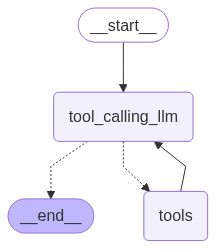

In [33]:
graph

## Invoking graph

Providing prompt in such a way that it interrupts the flow and requests human feedback.

In [44]:
prompt = "I need some expert guidance and assistance in building AI agents from scratch. Can you please connect me with an human expert?"

for event in graph.stream({"messages" : prompt}, config=config, stream_mode="values"):
    if  "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance in building AI agents from scratch. Can you please connect me with an human expert?
================================== Ai Message ==================================

I'd be happy to assist you with building AI agents from scratch.


### Observation 

As we can see, it is now waiting for some response from the human. To provide the input back, we need to use the `Command` class and can pass the data. 

In [45]:
human_response = (" We would recommend to checkout LangGraph in building your AI agents. It is much more reliable and extensible than simple agents.")

# Passing the above response to the flow 
command = Command(resume={"data" : human_response})

# resuming the flow 
for event in graph.stream(command, config=config, stream_mode="values"):
    if  "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'd be happy to assist you with building AI agents from scratch.
